In [4]:
from core.DataLoader import *
from core.models.MLP import * 
from core.models.GAM import *
from core.models.SVM import *
# from core.models.EBM import *

from core.models.RandomForest import *
from core.Visualizer import *
from core.models.Classifier import *
# import shap
import seaborn as sn

In [6]:
# weighted_clf_model_list ={
#     "MLP": MLPClassifier,
#     "DT": m_DecisionTreeClassifier,
#     "RF": m_RandomForestClassifier,
#     "LR": m_LogisticRegression,
#     "SVM": SVMClassifier
# }
# # weighted_clf_model_name_list = ['MLP', 'RF(5)', 'RF(10)', 'RF(U)', 'DT(5)', 'DT(10)', 'DT(U)', 'LR']
# weighted_clf_model_name_list = ['DT(5)']

# if 'MLP' not in weighted_clf_model_name_list[0]:
#     explainer = shap.TreeExplainer
# else:
#     explainer = shap.DeepExplainer
    

Using features:  ['left_cardinality', 'base_cardinality', 'sel_of_pred_on_indexed_attr', 'sel_of_pred_on_non_indexed_attr', 'sel_of_pred_on_indexed_attr_and_join_pred', 'sel_of_pred_on_non_indexed_attr_and_join_pred', 'sel_of_pred_on_indexed_attr_and_non_indexed_attr', 'total_sel_on_base_table', 'left_ordered', 'base_ordered', 'left_indexed', 'base_indexed', 'result_size', 'predicate_op_num_on_indexed_attr', 'predicate_op_num_on_non_indexed_attr']


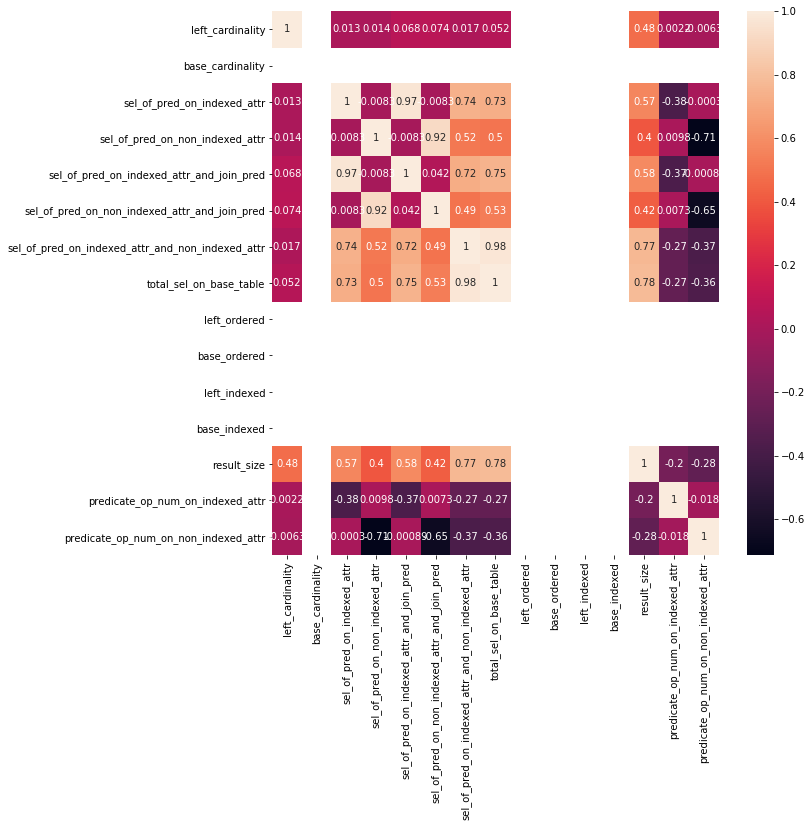

[Warning]: file ../../sample_results/tpch/nation/mssql_region_nation_optimal.csv does not exist. Passed.
[Warning]: file ../../sample_results/tpch/lineitem/mssql_orders_lineitem_optimal.csv does not exist. Passed.
Using features:  ['left_cardinality', 'base_cardinality', 'sel_of_pred_on_indexed_attr', 'sel_of_pred_on_non_indexed_attr', 'sel_of_pred_on_indexed_attr_and_join_pred', 'sel_of_pred_on_non_indexed_attr_and_join_pred', 'sel_of_pred_on_indexed_attr_and_non_indexed_attr', 'total_sel_on_base_table', 'left_ordered', 'base_ordered', 'left_indexed', 'base_indexed', 'result_size', 'predicate_op_num_on_indexed_attr', 'predicate_op_num_on_non_indexed_attr']


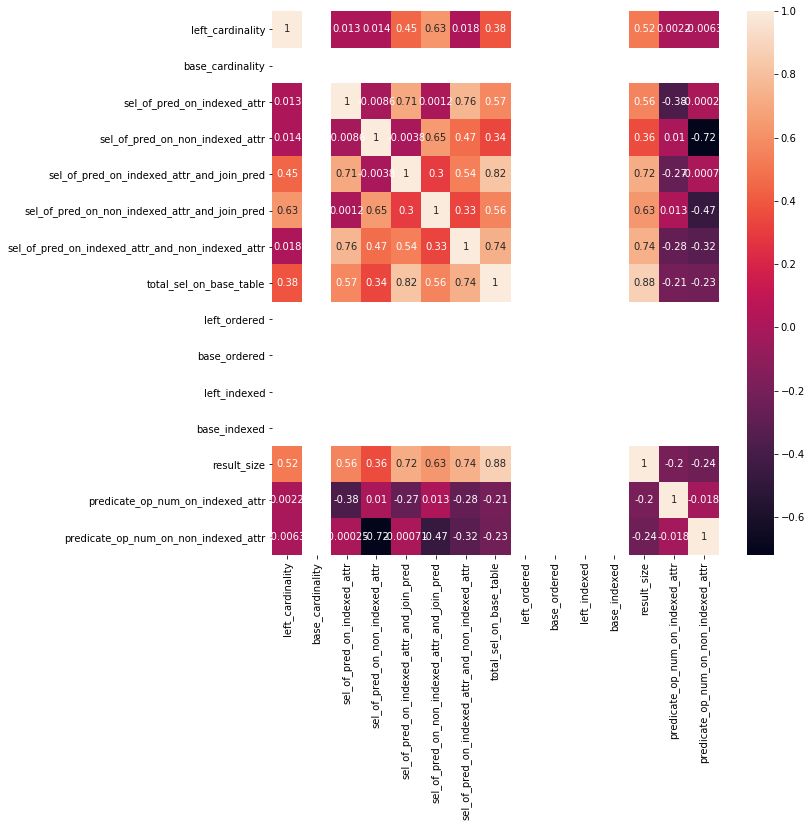

In [14]:
# feature_scores = {
    
# }

overall_imp = []

m_models = {
    'postgres': [],
    'mssql': []
}

# for f in features:
#     feature_scores[f] = 0

for engine in ['postgres', 'mssql']:
    dl = DataLoader(engine)
    one_file_dss, one_file_names = dl.get_one_file_ds(return_type='ds and names', datasets=['ssb', 'tpch', 'imdb'])


    all_features = dl.all_features
    classification_target = dl.classification_target

    features = all_features
    print("Using features: ", features)

    model_perf = {}
    
    importances = np.array([0. for i in range(len(features))])
    shap_values = np.array([0. for i in range(len(features))])
    
#     present_idxs = [i for i in range(len(one_file_dss))]
#     present_idxs = [0, 1, 2, 3, 4, 5, 8 ,12, 21, 22, 23, 24]
    present_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12, 13, 21, 22, 23, 24]

#     if engine == 'postgres':
#         present_idxs = [0, 1, 2, 3, 4, 5, 8 ,12, 22]
#     elif engine == 'mssql':
#         present_idxs = [0, 1, 2, 3, 4,5, 8 ,12, 21, 22]
        
    
    corrMatrix = None
    for i in present_idxs:
    #     i = 0
        # ds = one_file_dss[i][one_file_dss[i]['predicate_op_num_on_non_indexed_attr'] == 0]

        ds = one_file_dss[i]
        ds_name = one_file_names[i]


        if one_file_dss[i].shape[0] <= 0:
            continue

        # =========================
        X = ds[features]
        y = ds['optimal_decision']
        X_costs = ds[dl.regression_targets]

        if corrMatrix is not None:
            corrMatrix += X.corr()
        else:
            corrMatrix = X.corr()
    fig, ax = plt.subplots(figsize=(10,10))
    sn.heatmap(corrMatrix / len(present_idxs), annot=True, ax=ax)
    plt.show()
#         from sklearn.model_selection import train_test_split
#         from sklearn import preprocessing

#         X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
#         X_train_costs, _, _, _, = train_test_split(X_costs, y, train_size=0.8, random_state=1)
#         X_train, X_test, y_train, y_test = \
#             X_train.to_numpy(),X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

#         X_train_weights = calculate_importance_from_costs(X_train_costs.to_numpy())

#         scaler = preprocessing.StandardScaler().fit(X_train)
#         X_train = scaler.transform(X_train)

#         # scaler = preprocessing.StandardScaler().fit(X_test)
#         X_test = scaler.transform(X_test)

#         X_train_weights = preprocessing.MinMaxScaler().fit_transform(X_train_weights.reshape(-1,1)).flatten()
#         # =========================

#         accs = []
#         for idx, model_name in enumerate(weighted_clf_model_name_list):
#             model = weighted_clf_model_list[model_name.split('(')[0]]
#             if 'DT' in model_name or 'RF' in model_name:
#                 max_depth = model_name.split('(')[-1].split(')')[0]
#                 if max_depth.lower() == 'u':
#                     max_depth = None
#                 else:
#                     max_depth = int(max_depth)
#                 clf = model().fit(X_train, y_train, sample_weight=X_train_weights, max_depth=max_depth)
#             else:
#                 clf = model().fit(X_train, y_train, sample_weight=X_train_weights)

#             # print(f"Accuray of {model}: {clf.score(X_test, y_test)}")
#             m_models[engine].append(clf)
#             if len(features) == 2:
#                 plot_2d_decision_boundaries(clf, X_train, X_train_costs, y_train, title=f'{model} on {one_file_names[i]}')
#             accs.append(clf.score(X_test, y_test))

        # importances.append(clf.model.feature_importances_)

        
    
#         importances += np.array(clf.model.feature_importances_)
        
#         background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
#         vals= np.abs(explainer(clf.model, background).shap_values(X_train)).mean(0)
#         shap_values += sum(vals)


# feature maps:

In [12]:
corrMatrix

,left_cardinality,base_cardinality,sel_of_pred_on_indexed_attr,sel_of_pred_on_non_indexed_attr,sel_of_pred_on_indexed_attr_and_join_pred,sel_of_pred_on_non_indexed_attr_and_join_pred,sel_of_pred_on_indexed_attr_and_non_indexed_attr,total_sel_on_base_table,left_ordered,base_ordered,left_indexed,base_indexed,result_size,predicate_op_num_on_indexed_attr,predicate_op_num_on_non_indexed_attr
left_cardinality,1.000000,NaN,0.017154,0.025321,0.549595,0.642313,0.026379,0.472994,NaN,NaN,NaN,NaN,0.494749,-0.003739,-0.043886
base_cardinality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sel_of_pred_on_indexed_attr,0.017154,NaN,1.000000,-0.015065,0.753260,0.001253,0.716798,0.567815,NaN,NaN,NaN,NaN,0.549750,-0.351974,-0.016485
sel_of_pred_on_non_indexed_attr,0.025321,NaN,-0.015065,1.000000,0.000192,0.697971,0.539113,0.425767,NaN,NaN,NaN,NaN,0.413297,0.052882,-0.775391
sel_of_pred_on_indexed_attr_and_join_pred,0.549595,NaN,0.753260,0.000192,1.000000,0.344325,0.547034,0.792658,NaN,NaN,NaN,NaN,0.796044,-0.267637,-0.036067
sel_of_pred_on_non_indexed_attr_and_join_pred,0.642313,NaN,0.001253,0.697971,0.344325,1.000000,0.388075,0.661303,NaN,NaN,NaN,NaN,0.668441,0.050373,-0.549042
sel_of_pred_on_indexed_attr_and_non_indexed_attr,0.026379,NaN,0.716798,0.539113,0.547034,0.388075,1.000000,0.794278,NaN,NaN,NaN,NaN,0.770449,-0.220419,-0.410880
total_sel_on_base_table,0.472994,NaN,0.567815,0.425767,0.792658,0.661303,0.794278,1.000000,NaN,NaN,NaN,NaN,0.998550,-0.162449,-0.324473
left_ordered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
base_ordered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# All data

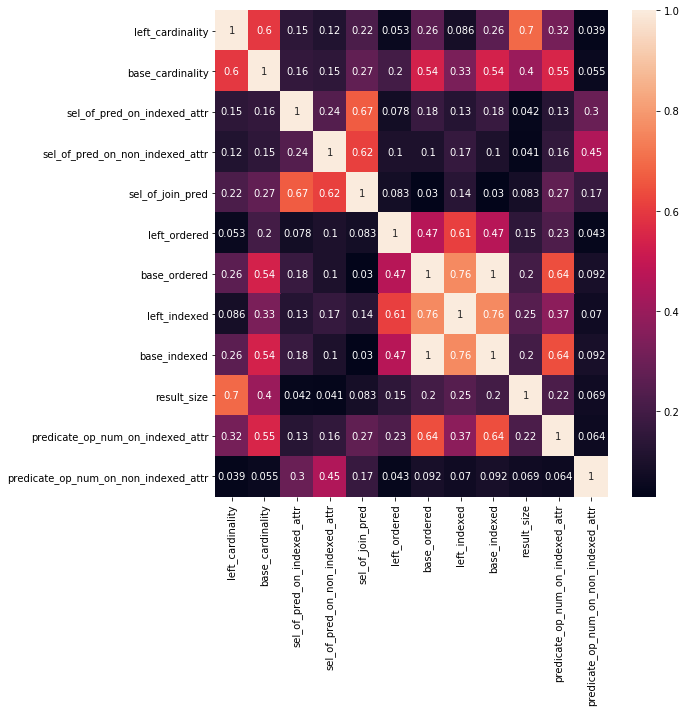

In [2]:
engine = 'postgres'
dl = DataLoader(engine)
ds = dl.get_all_files_ds(datasets=['tpch_100'])


all_features = dl.base_features
classification_target = dl.classification_target

features = all_features

X = ds[features]
y = ds['optimal_decision']
X_costs = ds[dl.regression_targets]

corrMatrix = X.corr()
data = corrMatrix.to_numpy()
data = np.abs(data)

# data[data < 0.5] = 0
df = pd.DataFrame(data, columns=corrMatrix.columns, index=corrMatrix.index)

fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(df, annot=True, ax=ax)
plt.tight_layout()
# plt.savefig(f'./figures/exp2-postgres-feat-corr.pdf')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in less


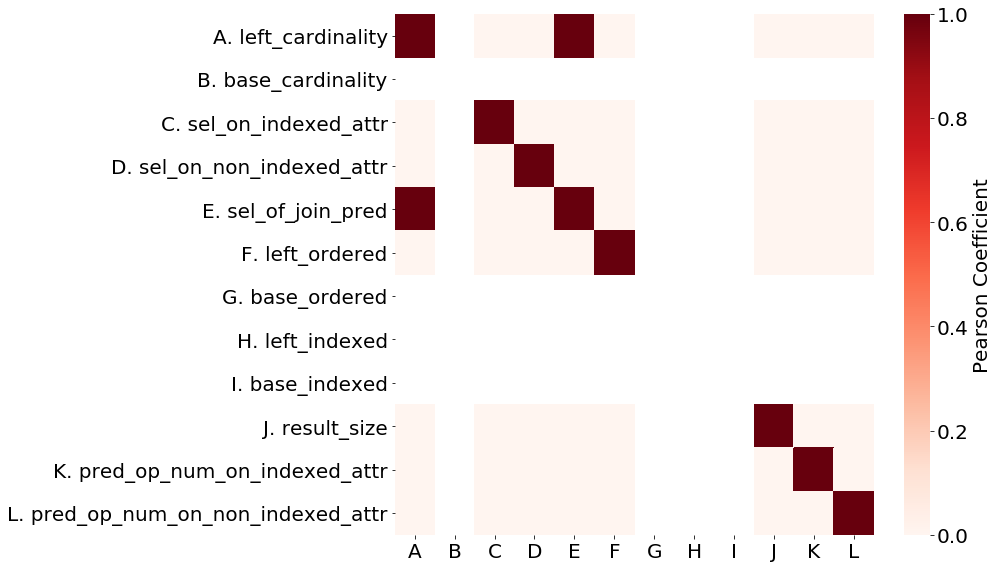

In [10]:
feature_names = ['left_cardinality', 'base_cardinality', 
                 'sel_on_indexed_attr', 'sel_on_non_indexed_attr', 
                 'sel_of_join_pred', 'left_ordered', 'base_ordered', 'left_indexed', 
                 'base_indexed', 'result_size', 'pred_op_num_on_indexed_attr', 
                 'pred_op_num_on_non_indexed_attr']


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# engine = 'postgres'
# dl = DataLoader(engine)
# all_ds = dl.get_one_file_ds(datasets=['ssb'], suffix='(random_left)')


# for i in range(len(all_ds)):
#     ds = all_ds[i]
# #     print(ds[['sel_of_join_pred', 'sel_of_pred_on_indexed_attr', 'sel_of_pred_on_non_indexed_attr']])
#     all_features = dl.base_features
#     classification_target = dl.classification_target

#     features = all_features
#     X = ds[features]
#     y = ds['optimal_decision']
#     X_costs = ds[dl.regression_targets]
#     corrMatrix = X.corr()
#     data = corrMatrix.to_numpy()
#     data = np.abs(data)

#     data[data < 0.8] = 0
#     df = pd.DataFrame(data, columns=feature_names, index=feature_names)
#     fig, ax = plt.subplots(figsize=(13,13))
#     sn_hm = sn.heatmap(df, annot=False, ax=ax, cbar_kws={'label': 'Pearson Coefficient'}, cmap=plt.cm.get_cmap('Reds'))
#     cax = plt.gcf().axes[-1]
#     cax.tick_params(labelsize=20)
    
#     cax = plt.gcf().axes[-2]
#     cax.tick_params(labelsize=20)
    
#     sn_hm.figure.axes[-1].yaxis.label.set_size(20)

#     plt.tight_layout()
#     plt.savefig(f'./figures/exp2-{engine}-feat-corr.pdf')
#     plt.show()
#     break


engine = 'mssql'
dl = DataLoader(engine)
all_ds = dl.get_one_file_ds(datasets=['ssb'], suffix='(random_left)')


for i in range(len(all_ds)):
    ds = all_ds[i]
#     print(ds[['sel_of_join_pred', 'sel_of_pred_on_indexed_attr', 'sel_of_pred_on_non_indexed_attr']])
    all_features = dl.base_features
    classification_target = dl.classification_target

    features = all_features
    X = ds[features]
    y = ds['optimal_decision']
    X_costs = ds[dl.regression_targets]
    corrMatrix = X.corr()
    data = corrMatrix.to_numpy()
    data = np.abs(data)

    data[data < 0.8] = 0
    df = pd.DataFrame(data, columns=indices, index=indexed_feature_names)
    fig, ax = plt.subplots(figsize=(14,8))
    sn_hm = sn.heatmap(df, annot=False, ax=ax, cbar_kws={'label': 'Pearson Coefficient'}, cmap=plt.cm.get_cmap('Reds'))
    
    
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=20)
    
    cax = plt.gcf().axes[-2]
    cax.tick_params(labelsize=20)
    
    sn_hm.figure.axes[-1].yaxis.label.set_size(20)
    
    
    plt.tight_layout()
    plt.savefig(f'./figures/exp2-{engine}-feat-corr.pdf')
    plt.show()
    break


# dl = DataLoader(engine)
# all_ds = dl.get_one_file_ds(datasets=['tpch_10'])


# for i in range(len(all_ds)):
#     ds = all_ds[i]
# #     print(ds[['sel_of_join_pred', 'sel_of_pred_on_indexed_attr', 'sel_of_pred_on_non_indexed_attr']])
#     all_features = dl.base_features
#     classification_target = dl.classification_target

#     features = all_features
#     X = ds[features]
#     y = ds['optimal_decision']
#     X_costs = ds[dl.regression_targets]
#     corrMatrix = X.corr()
#     data = corrMatrix.to_numpy()
#     data = np.abs(data)

#     # data[data < 0.5] = 0
#     df = pd.DataFrame(data, columns=corrMatrix.columns, index=corrMatrix.index)
#     fig, ax = plt.subplots(figsize=(10,10))
#     sn.heatmap(df, annot=True, ax=ax)
#     plt.tight_layout()
# #     plt.savefig(f'./figures/exp2-{engine}-feat-corr.pdf')
#     plt.show()
#     break

# dl = DataLoader(engine)
# all_ds = dl.get_one_file_ds(datasets=['tpch_100'])


# for i in range(len(all_ds)):
#     ds = all_ds[i]
# #     print(ds[['sel_of_join_pred', 'sel_of_pred_on_indexed_attr', 'sel_of_pred_on_non_indexed_attr']])
#     all_features = dl.base_features
#     classification_target = dl.classification_target

#     features = all_features
#     X = ds[features]
#     y = ds['optimal_decision']
#     X_costs = ds[dl.regression_targets]
#     corrMatrix = X.corr()
#     data = corrMatrix.to_numpy()
#     data = np.abs(data)

#     # data[data < 0.5] = 0
#     df = pd.DataFrame(data, columns=corrMatrix.columns, index=corrMatrix.index)
#     fig, ax = plt.subplots(figsize=(10,10))
#     sn.heatmap(df, annot=True, ax=ax)
#     plt.tight_layout()
# #     plt.savefig(f'./figures/exp2-{engine}-feat-corr.pdf')
#     plt.show()
#     break

In [5]:
feature_names

['left_cardinality',
 'base_cardinality',
 'sel_on_indexed_attr',
 'sel_on_non_indexed_attr',
 'sel_of_join_pred',
 'left_ordered',
 'base_ordered',
 'left_indexed',
 'base_indexed',
 'result_size',
 'pred_op_num_on_indexed_attr',
 'pred_op_num_on_non_indexed_attr']

In [6]:
indexed_feature_names = ['A. left_cardinality',
 'B. base_cardinality',
 'C. sel_on_indexed_attr',
 'D. sel_on_non_indexed_attr',
 'E. sel_of_join_pred',
 'F. left_ordered',
 'G. base_ordered',
 'H. left_indexed',
 'I. base_indexed',
 'J. result_size',
 'K. pred_op_num_on_indexed_attr',
 'L. pred_op_num_on_non_indexed_attr']

indices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']